<a href="https://colab.research.google.com/github/ismailkaya83/MY-DEEP-LEARNING-NOTEBOOKS/blob/master/Understanding_recurrent_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

As bold text you’re reading the present sentence, you’re processing it word by word—or rather, eye saccade by eye saccade—while keeping memories of what came before; this gives you a fluid representation of the meaning conveyed by this sentence. Biological intelligence processes information incrementally while maintaining an internal model of what it’s processing, built from past information and constantly updated as new information comes in.

A ***recurrent neural network*** (RNN) adopts the same principle, albeit in an extremely simplified version: it processes sequences by iterating through the sequence elements and maintaining a ***state*** containing information relative to what it has seen so far. In effect, an RNN is a type of neural network that has an internal loop (see figure 6.9). The state of the RNN is reset between processing two different, independent sequences (such as two different IMDB reviews), so you still consider one sequence a single data point: a single input to the network. What changes is that this data point is no longer processed in a single step; rather, the network internally loops over sequence elements.

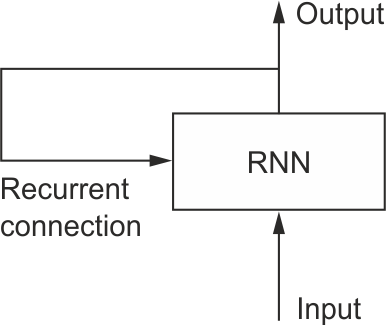

To make these notions of ***loop*** and ***state*** clear, let’s implement the forward pass of a toy RNN in Numpy. This RNN takes as input a sequence of vectors, which you’ll encode as a 2D tensor of size (timesteps, input_features). It loops over timesteps, and at each timestep, it considers its current state at t and the input at t (of shape (input_features,), and combines them to obtain the output at t. You’ll then set the state for the next step to be this previous output. For the first timestep, the previous output isn’t defined; hence, there is no current state. So, you’ll initialize the state as an all-zero vector called the ***initial state*** of the network.

In [ ]:
#RNN sozde kodu

state_t = 0     # t anindaki durum

for input_t in input_sequence: # dizi elemanlari uzerine doner
  output_t = f(input_t, state_t)
  state_t = output_t # onceki tekrarin ciktisi sonraki tekrarin durumu olur

# f fonksiyonunu daha acik sekilde yazarsak

state_t = 0
for input_t in input_sequence:
    output_t = activation(dot(W, input_t) + dot(U, state_t) + b)
    state_t = output_t

**Numpy implementation of a simple RNN**

In [3]:
import numpy as np

timesteps = 100            # dizideki zaman adimi sayisi
input_features = 32        # Girdi nitelik uzayinin boyutu
output_features = 64       # Cikti nitelik uzayinin boyutu

In [5]:
inputs = np.random.random((timesteps, input_features)) # girdi verisi : basitlik icin rastgele gurultu
inputs.shape

(100, 32)

In [7]:
state_t = np.zeros((output_features,)) # baslangic durumu tum elemanlari sifir vektor
state_t.shape

(64,)

In [8]:
# rastgele olusturulmus agirlik matrisleri

W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))

W.shape, U.shape, b.shape

((64, 32), (64, 64), (64,))

In [ ]:
successive_outputs = []

for input_t in inputs: # (input_features,) seklinde vektor
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b) 
    # girdi ve mevcut durumu birlestirerek simdiki ciktiyi uretir

    successive_outputs.append(output_t) # ciktiyi bir listede tutar

    state_t = output_t # sonraki adim icin agin durumunu gunceller

final_output_sequence = np.concatenate(successive_outputs, axis=0)
# (timesteps, output_features) seklinde son cikti

En basit haliyle RNN her dongu adiminda bir onceki adimin degerlerini kullanan bor for dongusunden baska birsey degildir. Elbette bu tanima uyan bircok RNN olusturulabilir, ama bu ornekte en basit RNN kullaniliyor. RNN ler step functions ile karakterize edilirler.

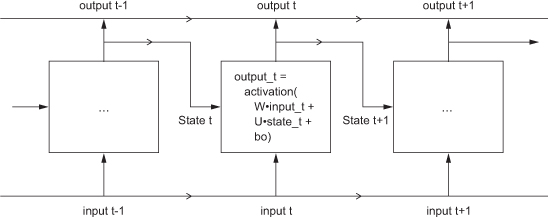

output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)

Not : Final output is a 2D tensor (timesteps, output_features) ve her zaman adimi (timesteps) t anindaki ciktiyi getirir. Her t zaman adimi cikti tensoru zaman adimi 0 dan t anina -tum gecmis- kadar olan bilgiyi icerir. Bu nedenle cogu kez ciktinin tum serisine ihtiyaciniz yoktur, sadece som ciktiya ihtiyaciniz vardir (dongunun sonundaki output_t). Cunku son cikti zaten tum gecmis hakkinda bilgiyi bulunduruyor.

**A recurrent layer in Keras**

Az once Numpy'de basit gerceklestirmesini yaptigimiz katman, aslinda Kras'ta SimpleRNN katmanidir.

from keras.layers import SimpleRNN

SimpleRNN ile Numpy ornegi arasinda kucuk bir fark vardir, tek bir girdi yerine yiginlara islem yapar, tipki Kerastaki diger tum katmanlar gibi. Yani girdi olarak (timesteps, input_features) yerine (batch_size, timesteps, input_features) alir.

SimpleRNN Kerastaki tum katmanlar gibi iki farkli modda calisabilir. 
- Her zaman adiminda (timstep) onceki tum cikti dizilerini ((batch_size, timesteps, output_features) seklinde bir 3D tensor) veya 
- sadece her girdi icin son katmanin ciktisini (batch_size, output_features) seklinde 2B tensor geri dondurebilir. 
Bu iki mod kurucu metodun return_sequences parametresi ile kontrol edilir.

SimpleRNN nin sadece son zaman adiminin son katmaninin ciktisini dondurdugu modda bir ornege bakalim.

In [9]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          320000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


Simdi de tum durum dizisini (full state sequence) donduren ornege bakalim.

In [10]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, None, 32)          2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


Bazen yinelemeli katmanlari ust uste getirmek agin gosterim gucunu artirmak acisindan faydali olabilir.

In [11]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))
model.summary()  

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 32)                2080      
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


**Bu modeli IMDB film kritigi siniflandirma probleminde kullanalim.**

In [12]:
# preparing the IMDB data

from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000   # nitelik olarak dusunulecek kelime sayisi
maxlen = 500           # metni 500 kelimeden sonra keser
batch_size = 32

print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)

print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Loading data...
17465344/17464789 [==============================] - 0s 0us/step
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
input_train shape: (25000, 500)
input_test shape: (25000, 500)


In [13]:
# Training the model with Embedding and SimpleRNN layers

from keras.layers import Dense

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 48s 308ms/step - loss: 0.6384 - acc: 0.6180 - val_loss: 0.5158 - val_acc: 0.7506
Epoch 2/10
157/157 [==============================] - 49s 313ms/step - loss: 0.3977 - acc: 0.8321 - val_loss: 0.4179 - val_acc: 0.8240
Epoch 3/10
157/157 [==============================] - 49s 311ms/step - loss: 0.3071 - acc: 0.8755 - val_loss: 0.4319 - val_acc: 0.7914
Epoch 4/10
157/157 [==============================] - 49s 310ms/step - loss: 0.2195 - acc: 0.9173 - val_loss: 0.4118 - val_acc: 0.8224
Epoch 5/10
157/157 [==============================] - 50s 318ms/step - loss: 0.1667 - acc: 0.9388 - val_loss: 0.3886 - val_acc: 0.8500
Epoch 6/10
157/157 [==============================] - 49s 313ms/step - loss: 0.1182 - acc: 0.9586 - val_loss: 0.4822 - val_acc: 0.8042
Epoch 7/10
157/157 [==============================] - 49s 309ms/step - loss: 0.0715 - acc: 0.9762 - val_loss: 0.7280 - val_acc: 0.7370
Epoch 8/10
157/157 [==============================] - 4

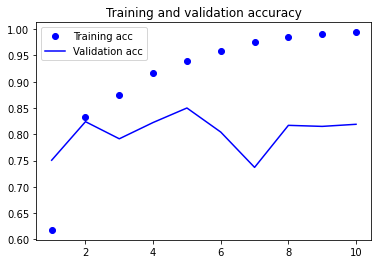

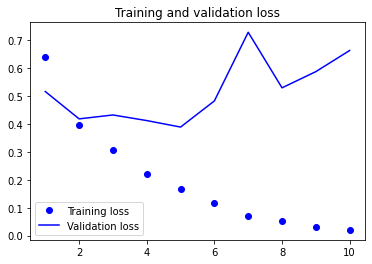

In [15]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Daha once IMDB seti icin naif yaklasimda daha yuksek bir basari elde edilmisti, burada performansin dusmesinin nedeni girdileriniz her bir kritik icin tum dizi yerine ilk 500 kelimeyi aliyor ve RNN temel modelden daha az veriye ulasiyor. SimpleRNN meting gibi cok uzun dizilerde kullanilmak icin cok uygun degil. Diger yinelemeli katmanlar daha iyi performans verirler.

**Understanding the LSTM and GRU layers**

SimpleRNN is not the only RNN in Keras. There are two others: LSTM and GRU. 
SimpleRNN'nin bir temel eksigi var: Teorik olarak t aninda onceki tum adimlardaki girdilerle ilgili bilgiyi tutabilir ancak uygulamada bu kadar uzun donemli gereksinimlerin ogrenilmesi imkansizdir. ***Vanishin gradient problem*** cok derin ileri yayilim aglarinda goruldugu gibi katman ekledikce agin egitilmez olmasidir.

LSTM gradyan yok olmasi probleminde cok etkili olmustur. LSTM tipki SimpleRNN nin farkli bir versiyonudur. Bircok zaman adiminin tasinmasini saglayan bir yol ekler. Islemeye calistiginiz dizi ile paralelde calisan tasiyici bir kayis dusunun. Dizideki bir bilgi herhangi bir noktada tasiyici kayisa gecebilir, boylece bir sonraki zaman adimina ulastirilir ve tekrar sizin ona ihtiyaciniz oldugunda eski yerine gecebilir. Boylece bilgiyi sonra kullanmak icin saklarken, eski sinyalin gradyan yok olmasi probleminden etkilenmesini egngeller.

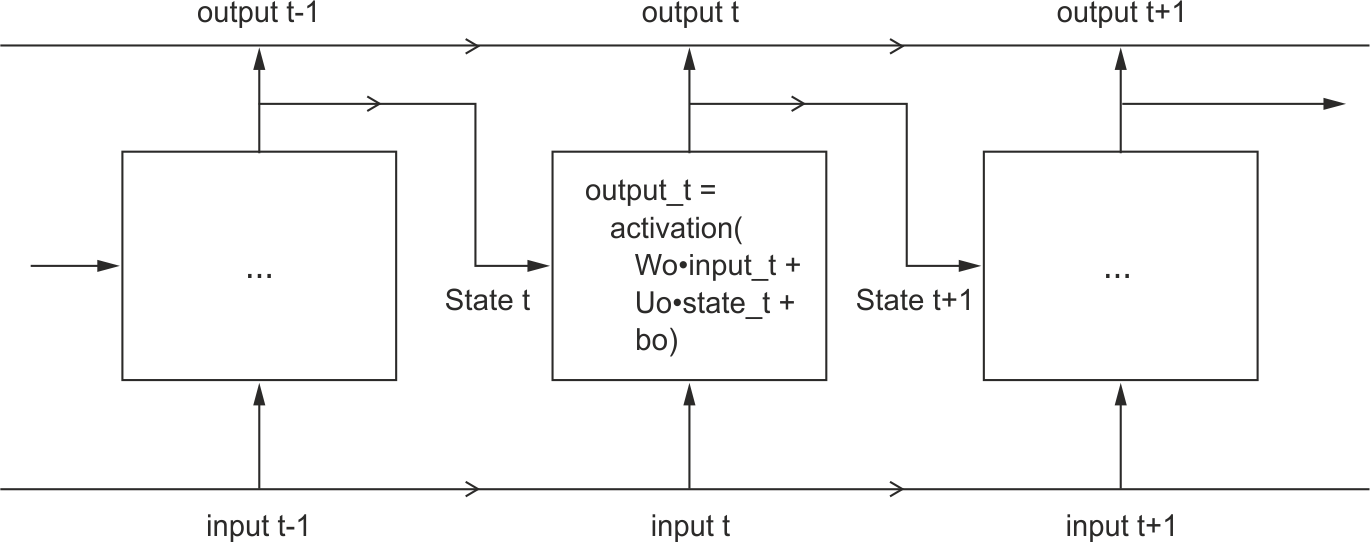

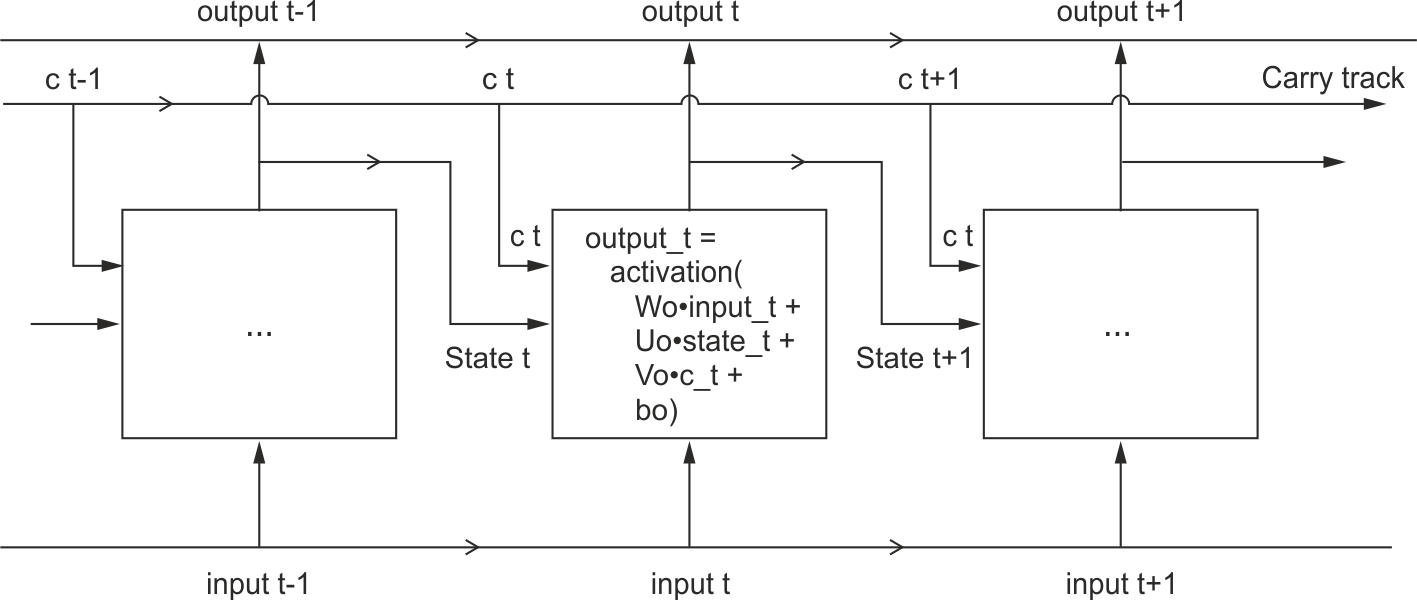

Ilk resim SimpleRNN semasi, ikincisi LSTM.
Ilk akisa zaman icerisinde bilgi tasiyan ek bir veri akisi daha ekleniyor. Ct olarak adlandirilan bu bilginin hucre uzerinde soyle bir etkisi olacak. Girdi ve yinelemeli baglantilari birlestirecek ve sonraki adima gonderilecek durumu etkileyecektir. Kavramsal olarak veri tasima akisi sonrasi ciktiyi ve sonraki durumu degistirecektir.

Veri tasima akisinin sonraki degerinin hesaplanmasinda bir incelik yapiliyor. Uc farkli donusum iceriyor ve bunlarin ucu de SimpleRNN hucresi formunda,

Ama uc donusum de kendi agirlik matrislerine sahipler ve onlari i, f ve k ile indeksleyelim. Su ana kadar geldigimiz asama yani LSTM nin son hali su sekildedir.

In [ ]:
# LSTM mimarisi sozde kodu

output_t = activation(dot(state_t, Uo) + dot(input_t, Wo) + dot(C_t, Vo) + bo)

i_t = activation(dot(state_t, Ui) + dot(input_t, Wi) + bi)
f_t = activation(dot(state_t, Uf) + dot(input_t, Wf) + bf)
k_t = activation(dot(state_t, Uk) + dot(input_t, Wk) + bk)

c_t+1 = i_t * k_t + c_t * f_t

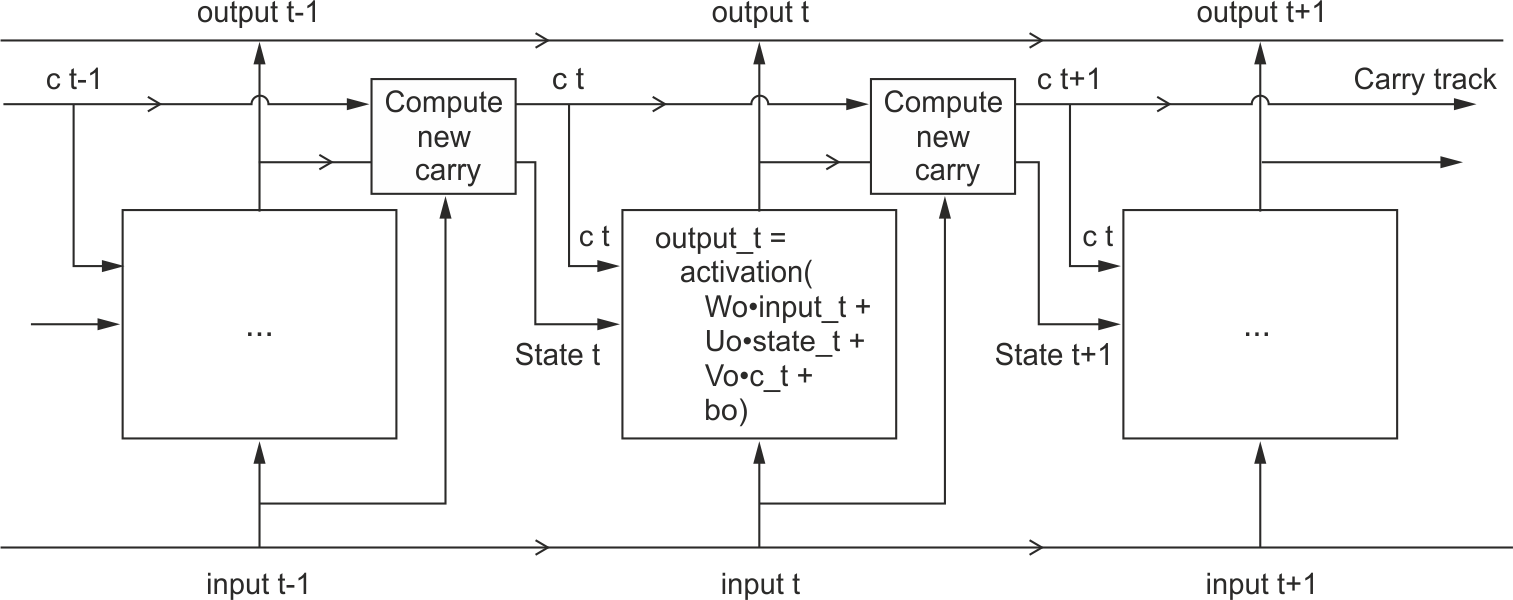

Felsefi olarak bakmak isterseniz her islemin ne yapmak istedigini alayabilirsiniz. Ornegin Ct ile Ft yi carpmak veri tasimadaki gereksiz veriyi unutmanizi saglar. Dahasi i_t ile k_t su an hakkinda bilgi verir ve veri tasyiciyi yeni veri gunceller.

Sonuc olarak bu detaylari anlamak zor ve cok gerekli degil, LSTM hucresinin ne anlama geldigini aklimizda tutmamiz yeter.

- ***Gecmis bilginin gelecege enjekte edilmesi ve boylece gradyan yok olasi problemi ile savasilmasi***
- ***allow past information to be reinjected at a later time, thus fighting the vanishing-gradient problem.***

**A concrete LSTM example in Keras**

Keras'ta LSTM kullanimi SimpleRNN ile aynidir. Sadece LSTM katmaninin cikti boyutunu belirtmek gerekiyor.

In [18]:
from keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 4s 29ms/step - loss: 0.5121 - acc: 0.7558 - val_loss: 0.3544 - val_acc: 0.8508
Epoch 2/10
157/157 [==============================] - 4s 25ms/step - loss: 0.3064 - acc: 0.8788 - val_loss: 0.3410 - val_acc: 0.8752
Epoch 3/10
157/157 [==============================] - 4s 25ms/step - loss: 0.2387 - acc: 0.9092 - val_loss: 0.3504 - val_acc: 0.8462
Epoch 4/10
157/157 [==============================] - 4s 25ms/step - loss: 0.2053 - acc: 0.9247 - val_loss: 0.3287 - val_acc: 0.8824
Epoch 5/10
157/157 [==============================] - 4s 25ms/step - loss: 0.1833 - acc: 0.9355 - val_loss: 0.3074 - val_acc: 0.8872
Epoch 6/10
157/157 [==============================] - 4s 26ms/step - loss: 0.1669 - acc: 0.9403 - val_loss: 0.3597 - val_acc: 0.8460
Epoch 7/10
157/157 [==============================] - 4s 26ms/step - loss: 0.1525 - acc: 0.9471 - val_loss: 0.3062 - val_acc: 0.8714
Epoch 8/10
157/157 [==============================] - 4s 25ms/step - 

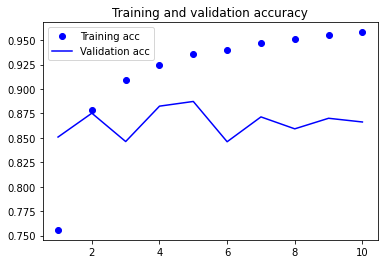

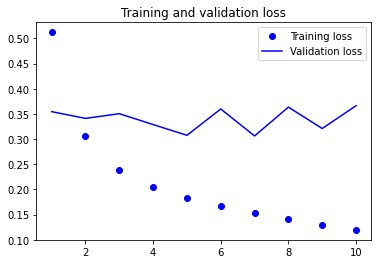

In [19]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

SimpleRNN de %81, LSTM de %86

Naif yontemle de benzer sonuclar aldik ama buradaki temel fark orada verinin tamamini kullanmak gerekirken LSTM ile sadece 500 adim kullanip kestik.

Ancak bu sonuclarda hesaplama maliyeti yusek olmasina ragmen cigir acan bir sey de yok. LSTM neden cok daha iyi degil? Birincisi, gomulme (embedding) boyutlari veya LSTM cikti cikti boyutu gibi hicbir hiperparametreyi ayarlamak icin denemeler yapmadik. Ikincisi, duzenlilestirme (regularization) kullanmamizdan olabilir. Aslinda ana neden, kririklerin genele hitap etmesi ve uzun donem yapisi (long term structure) ki LSTM bu konuda cok iyidir, duygu analizi probleminin cozumu icin yeterli degil. Bu tip bir problem her kritikte (review) bazi kelimelerin bulunusu ve frekansina bakilarak daha kolayca cozulecektir. Bu da ilk tamamen bagli katmanin (first fully connected) yaptigidir. 

**Wrapping up**

- What RNNs are and how they work
- What LSTM is, and why it works better on long sequences than a naive RNN
- How to use Keras RNN layers to process sequence data